# Final assignment project math 6181
## By: Mujtaba and Matthew
We start as always, with our general imports

In [ ]:
import jax
import jax.numpy as jnp
from jax import random as jrandom
from jax import nn as jnn
from jax import jit
import numpy as np
import random
import time
import sys
from matplotlib import pyplot as plt # plotting
import cantStopCode # cant stop game as made by prof (thank you)


Below is some global variables that appear throughout the code.

In [ ]:
key = jrandom.PRNGKey(0) # this is the random seed. 
THETA = jrandom.exponential(key, shape=(12,))
THETA = THETA.at[-1].set(20) #

# Incase things run weirdly
We found that sometimes, all out AI's would start reporting 0/10 wins. If this is the case its probably because the third aiDecision function ( the one with the argmax ) wasnt run and the code is using the method that randomly chooses. If so just rerun the correct aiDecision function and everything should work well. This comes from all the functions having the same name ( this allowed for code to be reused and explicitly showed how our work changed over time, but also lead to headaches as to which functions were used and saved sometimes ). 

# Describing the problem


To do this, we first need to describe the game of Can't Stop.
## Can't Stop
Consider the game of Can't Stop. This is a board game made back in 1981 and is a game where a group of players use their analysis of risk and suspeptibility to gambling to see who can first fill a certain number of columns by rolling two dice. In specific the rules of Can't Stop are as follows: <br>

- There are 10 columns, each labelled sequentially from $2$ to $12$. <br>

- Each column has a length corresponding sequentially as $\{3,5,7,9,11,13,11,9,7,5,3\}$, as shown [here](https://upload.wikimedia.org/wikipedia/en/0/04/CantStop-sm.png). <br>

- Each player takes turns one at a time. <br>

- On their turn, a player rolls four dice. They then choose to pair off the four dice into two sums. For example if the dice yield the numbers $\{6,5,4,2\}$ then the following sets of sums can be chosen: $\{(11,6), (10,7). (8,9)\}$. <br>

- A player must choose a set of sums which corresponds to their 'runners'. Runners are pieces that represent valid sum values. Each player can only have 3 runners. After selecting a sum that is valid for a runner, that runner is moved up one place in a column. If the player has no runners out, then they are placed to make a set of chosen sums valid and if no sums available are valid, then the player busts.  <br>

- When a player busts their turn ends and all runners are removed from the board. <br>

- After choosing a valid set of sums, the player has the choice to stop rolling. This turns all runners into saved progress along a column. <br>

- If a players saved progress in a column is equal to the length of the column they 'socre' the column. The first player to score 5 columns wins. <br>

This game is relatively simple, being one where players must understand basic probability rules along with the board state to make smart decisions. However this simple game has a considerable number of strategies. For example; one may notice that the '2' and '12' columns only require 3 values to completed. While these sums occur with low likeyhood it may be a valid strategy to invest in these columns over others. On the other hand, a player may realize that 7 is the most common result and attempt to have a runner in 7 no matter what. While these are two very different strategies, both seem very valid. This begs the question of "What is the optimal way to play". <br>
As per the course, our problem is finding a way to optimally play can't stop.


## Optimal player
To start, we need to define what an "optimal player" is. Optimal whose meaning is subjective. It may seem 'optimal' to always minimize the risk of busting in every scenario. However, this naive idea has an issue when we consider the length of columns. Since the safest options have the longest columns to progress through, a player only playing safely will lose against a player that takes some risk. As such a simple 'classical' optimization of the probabilities is not desired. Instead, our definition of optimal is very simple. Thus our definition of optimal is: <br>
### An optimal player is one that wins against the largest variety of opponents most of the time. <br>


# Trying the 'standard' method




### Computing the state space
To start we will only consider a two-player game. In reality, the data found from the two-player game could easily be used to generate a competent multiplayer game, but to simplify the problem from a computational standpoint let's only consider a game with two players. <br>
This makes the state space much simpler, as we do not need to consider whose turn it is. Instead, we can construct a state space where we are always the player playing and allow the 'enemy' to use the same state space, but with roles reversed. This brings the question of "how do we represent the game". Well, when one player is playing the player has the following information: 
- The progress of the player in each column.
- The location/progress of their runners.  
- The options of sums to take. 
- The progress of the enemy in each column. 
<br>

This is all the information present to a player during their turn. Now to represent the information. Since this game has been simulated via a python code, the choice of representation is somewhat forced. To start, the progress of each player can be represented by a numpy shape (11,) vector. Each entry is an integer representing the distance a player is from finishing. Since this is a two-player game, we require two (11,) shape vectors. The progress and location of the runners can be similarly recorded by a numpy shape (11,) whose integer entries represent the amount each runner has gone in each column. To denote the choice of columns a value of 0 just means a player has no runner in this column.  <br>
While this seems fine, we have found a bit of an issue. The methods used in class require a player to somehow traverse the state space, somehow learning the validity of actions (which is a bit more of a complicated interaction we will describe later). Thus we must ask ourselves, how big is the state space.
Well, each player vector can be represented by 3 ways in the first column, 5 ways in the second etc etc... this gives an upper estimate of $3^25^27^29^211^213 = 1404728325$ possibilities. Now since our state space was so simply constructed, we can use an upper estimate on the total size of the state space by taking three of these vectors. Considering them to be independent (technically the runner one is not but... we are looking at an upper bound so its fine) we get an upper bound on the size of the state space to be $1404728325^3 = 2.7718966e+27$. This is an insane size for a state space. While this is an upper estimate, even if only 0.01% of these states are even attainable or valid, the game has too many states. Instead, we will tackle this problem by using machine learning to tailor an AI as a player. This can be done, but we need to better understand how people play this game.  

## Trying a 'novel' method
To actually simulate more complicated AIs a variety of strategies must be considered. These strategies stem from basic interactions in the design of the game. For example, risky players are intinsically trying to use the skewed column lengths to their advantage, while conservative players with to use the probability distribution of two dice to their advantage. There are a few other interations that exist and can be implemented into our strategies. For example a could try to _snake_ an opponents column by completing it just as they closeto completion. In general these strategies will be called "behaviours" and we somehow need a way to represent these behaviours. To start we will quantify risky behaviour in a seemingly roundabout way.


# Trying to understand how players play




Logically the preference for a certain sum should be directly connected to its probability to occur. Provided we have no information about the board, we would naturally find the most probable sums to be the most preferred. To see the most probable sums, a simple computer simulation can be run. This is done below. <br>

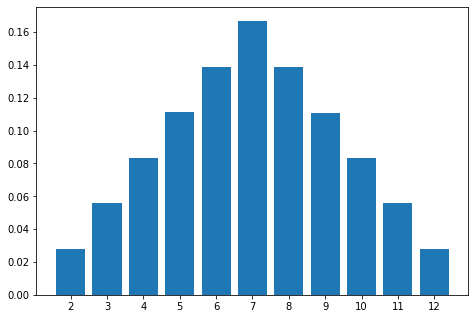

In [ ]:
def roll2():
  a = random.randint(1,6)
  b = random.randint(1,6)
  return(a+b-2)
iterations = 1000000
allRolls = np.array([0,0,0,0,0,0,0,0,0,0,0])
for i in range(iterations):
  allRolls[roll2()] += 1.0
allRolls = allRolls*(1/iterations)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
vals = ['2','3','4','5','6','7','8','9','10','11','12']
ax.bar(vals,allRolls)
plt.show()


## More information
As mentioend earlier Can't Stop keeps the game somewhat interesting by having variable lengths to each column. That is to say the 7 column needs 13 successful rolls to complete while the 2 column only needs 3. This skewed length naturally attempt to use the fact that the 2 and 12 columns in Can't Stop are incredibly short. This skewed length should be weighed in by our optimal player, but what makes a choice of 2 more desirable then a choice of 7. Consider if our player _chooses_ that they like 6 twice as much than 7, 5 twice as much as 6 etc etc etc. This person is simply taking this 'optimal' distribution and changing it by a weighting vector of: 
$$[16,8,4,2,\frac{1}{2},\frac{1}{4},\frac{1}{2},2,4,8,16]$$
Applying this scaling factor is done in the code below, and it provides a skewed distribution that represents a more _riskier_ play style. 


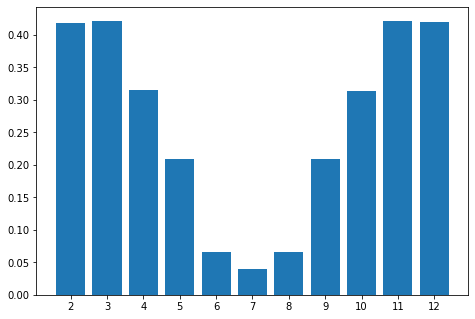

In [ ]:
# Add in a risky weighting
weights = np.array([16,8,4,2,1/2,1/4,1/2,2,4,8,16])
newRolls = np.multiply(allRolls,weights)
norm = np.linalg.norm(newRolls)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
vals = ['2','3','4','5','6','7','8','9','10','11','12']
ax.bar(vals,newRolls/norm)
plt.show()


## Another simple strategy
Consider if someone instead values stability and notices that, while nearly 5 times as long, a 7 occurs nearly 8 times that of a 2. This would give them a desire to instead choose the more 'safe' options. Again arbtirarily using 'twice as desired' as our metric, we obtain the following _desire distribution_. 

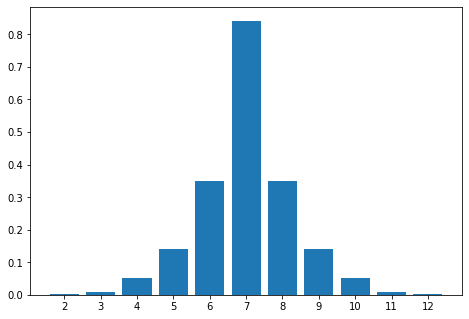

In [ ]:
# Add in a conservative weighting
weights2 = np.array([1/4,1/2,2,4,8,16,8,4,2,1/2,1/4])
newRolls = np.multiply(allRolls,weights2)
norm = np.linalg.norm(newRolls)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
vals = ['2','3','4','5','6','7','8','9','10','11','12']
ax.bar(vals,newRolls/norm)
plt.show()

## Viability
It seems that both strategies are equally viable, and it is hard to see which would win over a large number of games. Of course, this is mainly due to the two players basically playing in their own columns. 
## The importance of the visualization
While this does not seem to intuitively help, as both naive strategies seem equally valid, the act of visualization gives us the ability to model a player. A player can be nearly completely modelled by this distribution, which we will call a behavior profile $\mathcal{B}_P$. We are importantly missing what makes a player stop.


## When does a player stop
Consider what would make a player satisfied with their turn. There are many ways to quantify a 'successful' turn. But since we already have a representation of the players "wants" through its behavior profile, consider that a player is successful after enough of its wants are satisfied. This is actually quantifiable since the behavior profile is supposed to show a players wants. If we sum the wants satisfied by every action in a turn we can quantify the 'player satisfaction' as a number $S$. Once the player's satisfaction has hit some threshold, then they should stop their turn. Representing a successful turn this way is very alluring as calculating probabilities is never directly done and their calculations are imagined to be a relatively difficult both computationally and conceptually. With all of these considered, we can produce the following 'pseudo code' for a player.
```python
set: satisfyThreshold, behaviourProf
  while playerSatisfaction < satisfyThreshold:
    rollDice()
    getOptions()
    scoredOptions()
    action = max(scoredOptions)
    satisfyVal += options[action]
```


# Coding the novel AI


This type of method has not been done in course. It is most similar to the policy gradient method, but due since we have a deterministic policy it requires us to develop some critic function to score and change the player over games. Again, since the critic function will never change, this is not like the actor-critic method (and is why it will later fail). <br>
To start, we take the previous pseudo code and turn it into a deterministic function.


In [ ]:
# Our deterministic actor
def aiDecision(active_player_index, player_col_state, choices, legal, random_key, theta = THETA, PLAYER_COL_STATE_INIT=jnp.array([3,5,7,9,11,13,11,9,7,5,3])):
  # Inputs:
  # active_player_index, player_col_state, choices, legal, random_key defined as in the library
  # theta = An np array of size (12,) with theta[0:11] being its preferences and theta[10] being its satisfy value
  # Outputs:
  # choice_index; an integer represetning the chosen option
  # roll_again; a bollean; representing if the player ends its turn
  scoredOptions = (choices @ theta[0:11]) # scores our current options
  choice_index = jnp.argmax(legal*scoredOptions) # chooses best option that maximizes score 
  roll_again = theta[11] > scoredOptions[choice_index] # sees if it is satisfied enough before rolling again
  return choice_index, roll_again

## Code comments:
Note; so that it is easy to play against other AI's we include the same parameters, and also include one new default argument $\theta$. $\theta$'s first 11 arguments represent its behaviour profile, while its final one represents its satisfy threshold. 


## Having the player score its state
To easier take its gradient in the future, we take our scoring mechanism in aiDecision: 
```python
scoredOptions = (choices @ theta[0:11])
``` 
And condense in into a scalar, including the satisfy value through the line:
```python
playerVal = scoredOptions[chosenOption] - theta[11]
```
This acts like a value function, though we will call it the playerScore, since it represents the score the player thinks it has. 

In [ ]:

# Our value function
def playerScore(active_player_index, player_col_state, choices, legal, random_key, theta = THETA, PLAYER_COL_STATE_INIT=jnp.array([3,5,7,9,11,13,11,9,7,5,3])):
  # Inputs:
  # active_player_index, player_col_state, choices, legal, random_key defined as in the library
  # theta = An np array of size (12,) with theta[0:11] being its preferences and theta[10] being its satisfy value
  # Outputs:
  # playerScore = a float, represents how good the player thinks the taken action is

  # To make the code readable, we explicitly define everything

  scoredOptions = choices @ theta[0:11] # scores our current progress
  chosenOption = jnp.argmax(legal*scoredOptions)
  pScore = scoredOptions[chosenOption] - theta[11] # Finds the chosen scores, to incorporate the satisfy value, we subtract it from the scored option chosen
  return pScore

### Testing the naive AI
Now with the actor and loss function hard coded, we can test to see if it works. <br>
This function set will work if we get the expected output from some scenario, and take the gradient. This is done below.

In [ ]:
# tests if the hard coded actor and loss function work as expected
def test(active_player_index,player_col_state, choices, legal, theta):
  choice, roll = aiDecision(active_player_index, player_col_state, choices, legal, key, theta)
  pScore = playerScore(active_player_index, player_col_state, choices, legal, key, theta)
  print(choice, roll, pScore)

  gradVal = jax.grad(playerScore, argnums = 5) # takes derivative with resepct to theta
  print(gradVal(active_player_index, player_col_state, choices, legal, key, theta))


# Scenario;
option1 = jrandom.uniform(key,(11,), minval = 0.0, maxval = 1.0) # okay option
option2 = jnp.ones((11,)) # best option
option3 = jnp.zeros((11,)) # worst option
option3 = option3.at[10].set(0.5) # gives at least some reward for 3
choices = jnp.row_stack([option1,option2,option3])
theta = jnp.ones((12,)) # all 1's to represent theta
active_player_index = 1 
player_col_state = jnp.array([[3,5,7,9,11,13,11,9,7,5,3], [2,4,6,8,10,12,10,8,6,4,2]])
# In the first case, the second option is best and we are satisfied
# Expect:
# 1, False, 10
# gradient

legal = jnp.column_stack([True,True,True])
test(active_player_index,player_col_state, choices, legal, theta)

# In this the first option is best and we are satisfied
# Expect:
# 0, False, Given the randomness we cant actually know what pScore should be
# gradient 

choices = jnp.row_stack([option1,option2,option3])
legal = jnp.column_stack([True,False,True])
test(active_player_index, player_col_state, choices, legal, theta)

# In this the third option is best, but we are unsatisfied
# Expect:
# 2, True, -0.5
# gradient 

choices = jnp.row_stack([option1,option2,option3])
legal = jnp.column_stack([False,False,True])
test(active_player_index, player_col_state, choices, legal, theta)



1 False 10.0
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.]
0 False 3.621297
[ 0.88300896  0.13573384  0.6713624   0.72523665  0.34756768  0.33694267
  0.6773077   0.01929283  0.41512465  0.1611284   0.24859095 -1.        ]
2 True -0.5
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5 -1. ]


## Code comments
> There are some very odd issues here. Since we are just tacking on the satisfaction value the end via a subtraction, the gradient for our playerScore is always just -1. Honestly this is concerning and needs to be fixed later.

> We need to be slightly careful that the behaviour profile doesnt grow unboundedly. This can be fixed by normalizing the distribution after updating it.




## An objective scorer
To know if the player _actually_ did any better, we need an objective scoring function. This is like the critic in the actor critic set up. For now we will consider the weighted sum of player progress $\mathcal{P}_{P_i}$ against the enemies progress $\mathcal{P}_{E_i}$ and the column length $L_{i}$ given as: 
$$ v(s) = \sum^n_{i=0} \frac{L_i - \mathcal{P}_{P_i} + \mathcal{P}_{E_i}}{L_i} $$
Given how the source code is defined this comes down to: 
$$ v(s) = \sum^n_{i=0} \frac{\mathcal{E}_{col} - \mathcal{P}_{col}}{L_i} $$
where the col subscripts denote their column values. A function that evaluates this is written below.


In [ ]:
# Scores the players state
def scoreState(player_col_state, PLAYER_COL_STATE_INIT=jnp.array([3,5,7,9,11,13,11,9,7,5,3])):
  # Input:
  # player_col_state
  # Output:
  # score = a floating number, represents how well the player is doing via a weighted sum
  peProgress = jnp.subtract(player_col_state[0],player_col_state[1]) # We only need one subtraction here due to how the player col states are stored 
  score = jnp.sum(jnp.divide(peProgress,PLAYER_COL_STATE_INIT)) # does the weighted sum
  return score

## Code comments
> This is where we start adopting that our AI will have the active_player_index of 1 whenever we train. 

## Putting this together to develop a Machine Learning method
Let us ground ourselves by recalling what we have so far. We have:
- A determinstic actor, whose behaviour is determined by $\theta$, $\pi(\theta,S)$ [$\pi$ should be probabilistic but I don't have a better symbol] 
- An actor scoring function, $p(S,\theta)$, similar to a policy
- An objective value function, $v(S)$, like a critic <br>

We can now try to update our deterministic actors parameters $\theta$ by using a weird combination of policy graident and actor-critic. Lets try updating via:
$$ \theta = \theta + L\cdot((v(S_t) - v(S_{t-1})) \cdot \nabla_{\theta}(p( S_t, \theta)) $$ 

This update function is below. 



In [77]:
gradOfLoss = jax.grad(playerScore, argnums = 5) # takes gradient with respect to theta, we do this once to save computation time
LEARNINGRATE = 0.2 # we globally define this for now

def changeTheta(scoreOld, scoreNew, playerScore, active_player_index, player_col_state, runner_choices, runner_legal, key, theta, learningRate = LEARNINGRATE):
  scoreNew = scoreState(player_col_state) 
  gradOfLoss = jax.grad(playerScore, argnums = 5) # takes gradient with respect to theta
  theta = (theta + learningRate * (scoreNew - scoreOld)*gradOfLoss(active_player_index, player_col_state, runner_choices, runner_legal, key, theta)) # see earlier formula
  return(theta)


NameError: ignored

## Simulating a game
Now with a updating function defined, we can simulate a game and run update as the game goes. To do this, we need to change the library's game function. This is done below 


In [ ]:
LEARNINGRATE = 0.2 #global variables dont hate me

# A function that lets us play a game against an enemy
def simluateToTrain(enemyAI, theta, N_PLAYERS=2, N_COL_TO_WIN=5, N_MAX_RUNNERS=3, PLAYER_COL_STATE_INIT=[3,5,7,9,11,13,11,9,7,5,3], learningRate = 0.5):
  '''Run a simulation of the game Can't Stop!'''
  #Input:
  # same as in the library
  # theta; a 12 sized jnp array, this is the 'policy' we are training 
  #Output:
  # theta; the same parameters for our policy after undergoing training
     
  # Initialize game 
  player_col_state = jnp.tile(jnp.array(PLAYER_COL_STATE_INIT,dtype=jnp.dtype('i1')),(N_PLAYERS, 1))
  game_in_progress = True
  active_player_index = random.randint(0,N_PLAYERS-1) 
  random_key = jrandom.PRNGKey(int(time.time()))
  # Play game
  while game_in_progress:   
    #Initalize turn
    active_player_index = (active_player_index + 1) % N_PLAYERS
    runner_col_state = jnp.zeros( 11 ,dtype=jnp.dtype('u1'))
    not_busted_state = True
    roll_again_state = True    
    if active_player_index == 1: # If the AI's turn, scores its board before its action
      scoreOld = scoreState(player_col_state) 
    # Player plays a turn
    while roll_again_state: 
      # Rolls dice, find legal optoins, checks if busted
      random_key, subkey_1, subkey_2 = jrandom.split(random_key, 3)
      dice_num =  int(jrandom.randint(subkey_1, (1,), 0,1296))
      runner_choices, runner_legal = cantStopCode.generate_all_choices_and_legality(dice_num,player_col_state,runner_col_state, N_MAX_RUNNERS)
      any_legal_choices = jnp.any(runner_legal)
      not_busted_state = not_busted_state and any_legal_choices

      if not_busted_state:
        if active_player_index == 1: # AI does its turn
          choice_index, roll_again_state = aiDecision(active_player_index, player_col_state, runner_choices, runner_legal, random_key,theta)
        else: # enemy does its turn
          choice_index, roll_again_state = enemyAI(active_player_index, player_col_state, runner_choices, runner_legal,  random_key)
        # forces players to stop if it must
        if runner_legal[choice_index] == False:
          not_busted_state = False  
        runner_col_state = runner_choices[choice_index]
      roll_again_state = roll_again_state and not_busted_state    
    # resolves turn
    runner_col_state = runner_col_state*not_busted_state
    player_col_state = cantStopCode.update_player_col_state(active_player_index,player_col_state,runner_col_state) 

    if active_player_index == 1: # If its the AI's turn, scores the new state and does machine learning
      scoreNew = scoreState(player_col_state) # Scores the player's board after its action 
      theta = changeTheta(scoreOld, scoreNew, playerScore, active_player_index, player_col_state, runner_choices, runner_legal, key, theta) # changes theta
    player_N_col_claimed = cantStopCode.calculate_player_N_col_claimed(player_col_state)
    game_in_progress = not jnp.any(player_N_col_claimed >= N_COL_TO_WIN)
  return ( theta )



## Making sure the simulator works
To make sure the simulator runs and all the code is sound, we run 10 simulations against the random AI below. 

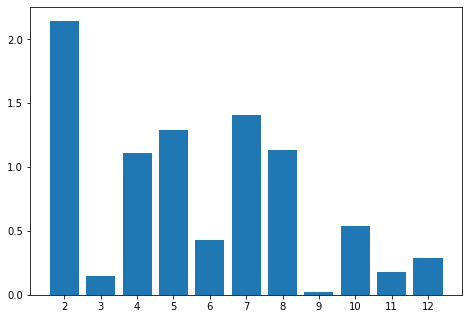

10.0


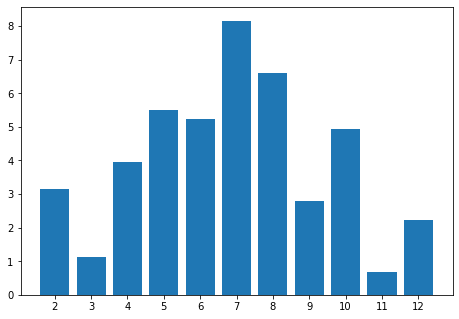

-1.6191589


In [ ]:
enemyAI = cantStopCode.pure_random_AI
theta = jrandom.exponential(key, shape=(12,))
theta = theta.at[-1].set(10) # hard code the satisfy value

# visualize our old theta
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
vals = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
ax.bar(vals,theta[0:11])
plt.show()
print(theta[11])

for x in range(10): # simulate 10 games
  theta = (simluateToTrain(enemyAI,theta))

# visualize our new theta
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
vals = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
ax.bar(vals,theta[0:11])
plt.show()
print(theta[11])

## Seeing if we are getting better
Now with the basics implemented, we can define some helper functions to make our lives easier and train our AI. All these helper functions are below and include:
- initTheta. A function to quickly and convinently initalize theta with random values between 0 and 1 for its behaviour profile and a fixed satisfy value. 
- visualizeTheta. A function that quickly and convinently plots theta and prints its satisfy value. Handy to see if things are working as expected. 
- trainAI. This function just takes our AI and plays it against a group of enemies.
- trainAndCheckProgress. This function trains our AI against some group for some set of training values. After doing so it plays against the same AI group to see how it fairs. This is very good to see if the AI is getting better as training goes on. 


In [ ]:
# Initalizes theta with random values and a fixed satsify value.
# NOTE, the satisfy value is hard coded to start at 20
def initTheta(theta, randKey = key, satVal = 20):
  theta = jrandom.exponential(randKey, shape=(12,))
  theta = theta.at[-1].set(satVal)
  return(theta)

# Visualizes the behaviour profile as a bar graph, and spits out the satisfy value via a print statement.
def visualizeTheta(theta) :
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  vals = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
  ax.bar(vals,theta[0:11])
  plt.show()
  print(theta[11])

# trains our AI against a group of enemies a certain number of times
def trainAI(enemyAI, theta, itsToTrain = 1000):
  # Inputs: 
  # enemyAI = a list of functions, representing the enemies
  # itsToTrain = an integer, represents the nubmer of games to train the AI
  # theta =... theta we have defined this like 100 times 
  # Outputs: 
  # theta 
  for x in enemyAI:
    for y in range(itsToTrain):
      theta = simluateToTrain(x,theta)
  return(theta)

# trains our AI against enemies for multiple sessions, checking its progress along the sessions.
GAMENUM = 20
def trainAndCheckProgress(theta,enemyAI,trainVals,aiDecision, gameNum = GAMENUM):
  for trainVal in trainVals:
    global THETA # Note we update the global THETA here, just incase we want to play against aiDecision before its training
    THETA= theta # this sets our global variable theta, so we can play against other people using the libraries code
    print(f"Below are results for {trainVal} training sessoins:")
    theta = trainAI(enemyAI,theta, itsToTrain = trainVal) 
    for idx,enemy in enumerate(enemyAI):
      print(f"Against AI {idx}")
      cantStopCode.play_N_games(gameNum,[aiDecision,enemy])
    visualizeTheta(theta)
  return(theta)


Putting this all together, we can run the following code block to check how the AI is doing, and if its learning as we expect. <br>
To start, we train the AI against the three given AI enemies at after 0, 10, 20 and 50 games. <br>
The next code block runs it for 100 against all three AIs resulting in 300 games of training. <br>

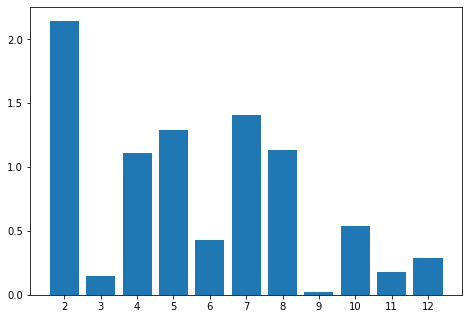

20.0
Below are results for 0 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 0 20]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 4 16]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 1 19]


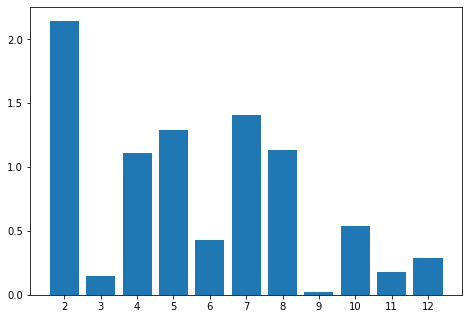

20.0
Below are results for 10 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 7 13]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 4 16]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 4 16]


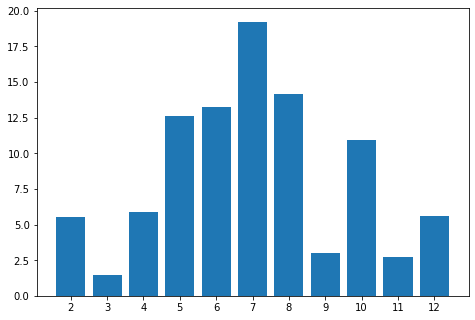

-7.581274
Below are results for 20 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 4 16]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 4 16]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 0 20]


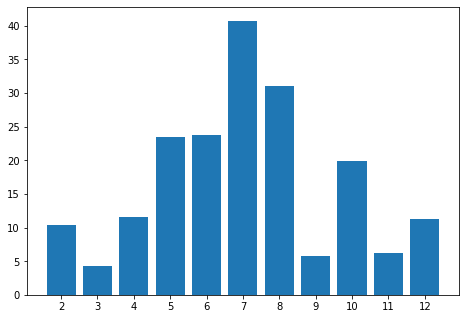

-55.88028
Below are results for 50 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 4 16]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 2 18]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 4 16]


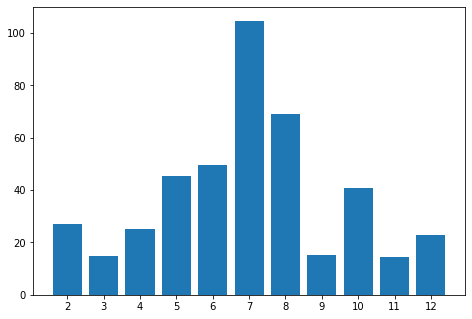

-179.35004
Below are results for 100 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 4 16]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 0 20]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 0 20]


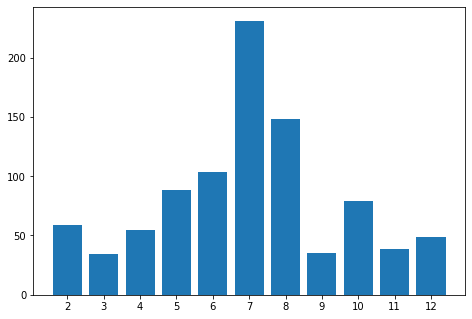

-432.39938
Below are results for 200 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 4 16]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 0 20]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  20  winners are  [ 0 20]


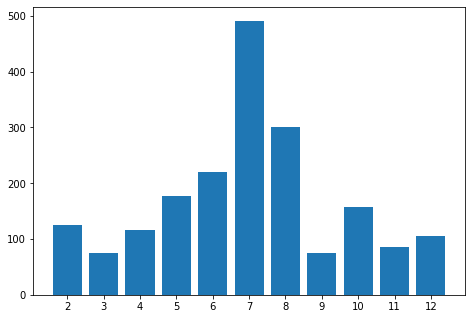

-951.454


In [ ]:
enemyAI = [cantStopCode.pure_random_AI, cantStopCode.random_timid_AI, cantStopCode.runner_weights_AI]
theta = initTheta(theta)
THETA = theta
trainVals = [0,10,20,50,100,200]
visualizeTheta(theta)
theta = trainAndCheckProgress(theta,enemyAI,trainVals,aiDecision)
np.savetxt('novel.txt', theta, fmt='%d')


# Analysis of novel approach


After running the initial tests, here is how the AI preformed. Each column is an AI type, and each row is after a certain number of training sessions. The win to loss ratio is reported as [Wins,Losses]

Sessions | Pure random | Timid | Weights 
---------|-------------|-------|--------
0|[4,16]|[7,13]|[0,20] 
10|[3,17]|[4,16]|[0,20] 
20|[2,18]|[5,15]|[1,19] 
50|[6,14]|[0,20]|[4,16] 
100|[2,18]|[0,20]|[0,20] 
<br>

These results are concerning. It seems that our AI is getting _worse_ in general as it trains. With the exception of 50 training sessions, it never even gets significant wins against the runner_weights AI. Infact, if the visualizations are looked at, the satisfy value becomes an alarming -238 after 300 training games.<br>
This frankly comes from our implementation of the intuitive method. 



## (Probably) Why it fails
The AI as written now, has a deterministic actor that is being trained by a very simple value function, this being the scoring state function. The issue doesn't come from using this hacked value iteration method, but instead from the object we are taking the gradient of. That is the playerScoring function or $p(S)$. This function attempts to emulate what is normally a probability distribution by instead taking the valid option and taking on a subtraction sign with the satisfy value. This naive (and retroactively dumb) choice forces the derivative to be a constant negative value with respect to the satisfy value, leading to the incredible -200 after 300 training games. While this method failed, it can be saved. It just requires us to change our functions to better encapsulate the concept of 'probability distriubion' as seen in the course in so far. 
 

# Turning our AI probabilistic

We need to turn our AI into one that chooses probabilisically. That is to say, have our 'scoring functions' spit out functions that are probabilities. Luckily this is a simple change but requires a few steps:<br>



## Changing our AI

> To start, lets deal with how we obtain the choice_index. Beforehand we used jnp.argmax to choose the score which obtained the highest value. Instead, we want to produce a probabilistic AI. To start, lets produce a probability distribution from our scored options. This can be done by using jnp.softmax on our scored options. We can then choose a choice_index by randomly picking a column. The code for this was actually made in assignment one, so we will just reuse our code from there and call it chooseIndex. All in all, this changes our choice_index line as follows:
<br>

```python
choice_index = jnp.argmax(legal*scoredOptions) # Old
choice_index = chooseIndex(jnn.softmax(legal*jnp.add(scoredProgress,scoredOptions))) # new
``` 
<br>

> We can similarly change our choice to stop rolling from a deterministic evaluation into a chance, based upon our current satisfy value. For this we chose an arctan function. The reasons come from a bunch of work, but instead of explaining how we chose this somewhat arbtirary function we will instead act like we chose it by accident initially. The chosen function is:
$$ p_{roll} = \frac{arctan(s_{chosen}-\theta_{11}) + 1.5}{3} $$
This changes our code as follows:
```python
roll_again = theta[12] > scoredOptions[choice_index] # Old
roll_again = random.random() > (jnp.arctan(scoredOptions[choice_index] - theta[11]) + 1.5)/3 # New
```
<br>

> Now, since future work will require us to take the gradient of these probabilities, it is easiest to just have these lines of code kept as seperate functions that output the probabilities.  

All of this culminates in the following new aiDecision and probabilistic function:


In [ ]:

# nothing new about this, just helped with running stuff in the jyupter notebook
def initTheta(theta, randKey = key, satVal = 2):
  theta = jnn.softmax(jrandom.exponential(randKey, shape=(12,)))
  theta = theta.at[-1].set(satVal)
  return(theta)

# nothing new about this, just helped with running stuff in the jyupter notebook
def visualizeTheta(theta) :
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  vals = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
  ax.bar(vals,theta[0:11])
  plt.show() # behaviour profile
  print(theta[11]) # sat val

theta = jnn.softmax(jrandom.exponential(key, shape=(12,)))  # just incase.
theta = initTheta(theta)
THETA = theta

# See problem 1 assignment 1 for more details
def chooseIndex(probDist):
  random.seed()
  rand = random.uniform(0,1)
  cumVec = np.cumsum(probDist) # generates the cumulative sum to incorporate U
  choice = np.searchsorted(cumVec,rand, side = 'left') 
  return choice

# Outputs the prob dist for choosing columns
def aiChoiceProbabilistic(choices, legal, theta):
  # Inputs:
  # choices, legal, theta as defined earlier
  # Outputs:
  # thetaToChooseFrom = An np array of size (11,) which is the probability distribution of our AI choosing any of the columns
  scoredOptions = (choices @ theta[0:11]) # scores our current options
  thetaToChooseFrom =jnn.softmax(legal*scoredOptions) # generates prob dist using softmax
  return (thetaToChooseFrom)

# Outputs the prob dist for choosing to roll again
def aiRollProbabilistic(choices, choice_index, theta):
  scoredOptions = (choices @ theta[0:11])
  rollAgainChance = (jnp.arctan(scoredOptions[choice_index] - theta[11]) + 1.5)/3# = ~ 0.04 if 3 behind the satisfy value . 
  return([rollAgainChance, 1 - rollAgainChance])

# The actor which spits a choice based upon its probability distribution
def aiDecision(active_player_index, player_col_state, choices, legal, random_key, theta = THETA, PLAYER_COL_STATE_INIT=jnp.array([3,5,7,9,11,13,11,9,7,5,3])):
  # Inputs:
  # same as earlier
  # Outputs:
  # choice_index; an integer represetning the chosen option
  # roll_again; a bollean; representing if the player ends its turn
  thetaToChooseFrom = aiChoiceProbabilistic(choices,legal,theta)
  choice_index =  chooseIndex(thetaToChooseFrom)
  roll_again = random.random() > aiRollProbabilistic(choices, choice_index, theta)[0] # if = 1, then approx 70% to roll again
  return (choice_index, roll_again)

## Changing how our machine learns
Armed with this probabilistic method, we can now use a new method to update our AI. Inclass this is known as the "policy gradient method" and allows us to update $\theta$ after a game with: <br>

$$ \theta = \theta + L\cdot G \cdot \nabla(ln(\pi(A_t | S_t, \theta) $$  

In this equation $G$ is the sum of our rewards over our actions and $L$ is our learning rate. Due to the construction of the game $G$ will only reward wins with $1$ and everything else with $0$. <br>
To implement this, we need to change our function that simulates a game.



## A quick caveat 

Notice in the policy gradient formula, we need to store our actions and states at every time step. This can be done, but since the objects for our state at every time step are a few np arrays of varying size, we generate a python class called state record and update this. This class is below:<br>
Note, we incorproate a maxTurn value of 100 for two reasons. One numpy arrays need to have a finite size and two, we only need to consider a max of 100 turns because if a player only had the ability to advance one runner a turn and decided to fill every single column before completing one they would be forced to finish the game after about 80 turns. We expect our AI to be considerably better than this, so lets just disregard anything that takes more than 100 turns to complete. 



In [ ]:
class StateRecord:
  def __init__(self,maxTurns):
    self.col = np.zeros((maxTurns,2,11)) # stores the player col state, which is (2,11) because we have two players
    self.choice = np.zeros((maxTurns,9,11)) # stores the possible options, which is (9,11)
    self.legal = np.zeros((maxTurns,9)) # stores which optiosn are legal, which is (9,)
    # self.random = np.zeros((maxTurns,)) # technically these will always be the same and arent even used by the function, we just have it as parameters so we can play against others in the future

  def update(self, turnNum, player_col_state, runner_choices, runner_legal):
    self.col[turnNum] = player_col_state
    self.choice[turnNum] = runner_choices
    self.legal[turnNum] = runner_legal

## Implementing learning
With this new equation, we also need to update the changeTheta function. To do this we need to take a log of a function. This is most easily done via pythons lambda functions. For simplicity we will start with only dealing with the roll_again function, but this works as:<br>
```python 
logAiProbRand = (lambda a,b,c : jnp.log(aiRollProbabilistic(a,b,c)[0]), lambda a,b,c : jnp.log(aiRollProbabilistic(a,b,c)[1]) )
```
After the log of the function is obtained, we can take the gradient for all possible actions. 
```python
gradLogAiProbRand = jax.jit(jax.grad(logAiProbRand[0], argnums=(2))), jax.jit(jax.grad(logAiProbRand[1], argnums=(2))) 
```
Later on we just evaluate this list of functions for the action taken and move on. 
``` python
theta+= learningRate*(gradLogAiProbRand[rollChoice](pChoice,colChoice,theta))
```

In [ ]:
# We compute the gradient as a.... global function? mainly to save time. This is very ugly in terms of coding practice, but its REALLY convinent 
# deals with the roll again chance
logAiProbRand = (lambda a,b,c : jnp.log(aiRollProbabilistic(a,b,c)[0]), lambda a,b,c : jnp.log(aiRollProbabilistic(a,b,c)[1]) ) # obfuscated but efficient
gradLogAiProbRand = jax.jit(jax.grad(logAiProbRand[0], argnums=(2))), jax.jit(jax.grad(logAiProbRand[1], argnums=(2))) # obfuscated but efficient
# deals with the behaviour profile, theta
# logAiProbChoice = (lambda a,b,c : jnp.log(aiChoiceProbabilistic(a,b,c)[colChoice])) #use actions as index
# gradLogAiProbChoice = jax.jit(jax.grad(logAiProbChoice, argnums=(2))) #argnum theta

# the function that actually does the learning, note we assume we won the last game and our reward is 1
def changeTheta(theta,playerStateRecord,playerActionRecord, reward, learningRate = 0.2):
  # Inputs
  # theta; a 12 sized jnp array, this is the 'policy' we are training 
  # playerStateRecord; a list with dimensions [t,5] 5 being from our state at every time step (active_player_index, player_col_state, runner_choices, runner_legal, theta)
  # playerActionRecord; a list with dimensions [t,2] 2 being from our actions at every time step (choice index, roll again state) 
  # Outputs
  # theta; updated via policy grad method
  if reward != 0: # note, we just ignore the data set if the reward is 0 since our player lost those
    for t in range(1,len(playerActionRecord)): 
      colChoice = int(playerActionRecord[t][0])
      rollChoice = int(playerActionRecord[t][1])
      pCol = playerStateRecord.col[t]
      pChoice = playerStateRecord.choice[t]
      pLegal = playerStateRecord.legal[t]
      theta+= learningRate*(gradLogAiProbRand[rollChoice](pChoice,colChoice,theta)) # chooses derivative based on our roll again choice
      # theta+= learningRate*gradLogAiProbChoice(pChoice,pLegal,theta) # chooses derivative based on our column choice
  return(theta)
  

## New game simulator
With the learning set up, we now must change our game simulation, since we don't update after every game anymore. Theres a few things that need to be changed. To start:<br>
### Recording our AI
> To record the states and our actions we use the previous class and a numpy array and update it after everyone of our turns. <br>

```python
# initalized as
playerActionRecord = np.zeros((maxTurns,2))
playerStateRecord = StateRecord(maxTurns)
# used as 
if active_player_index == 1 and turnNum < maxTurns: # records everything
  playerActionRecord[turnNum][0] = choice_index
  playerActionRecord[turnNum][1] = roll_again_state 
  playerStateRecord.update(turnNum, player_col_state, runner_choices, runner_legal)
  turnNum += 1
```

### Recording 
> To record if we won or lost, we simply check if the winning player is player 1 or not and give a reward of one if we won. This is implemented through: <br>

```python
# initialized as
reward = 0
# used as
if active_player_index == 1: # This means our AI won, possibly by timeout, 
  reward = 1 
```

This ultimately culminates in the following code. 



In [ ]:
LEARNINGRATE = 0.2 #global variables dont hate me

# A function that lets us train against our enemies
def simluateToTrain(enemyAI, theta, N_PLAYERS=2, N_COL_TO_WIN=5, N_MAX_RUNNERS=3, PLAYER_COL_STATE_INIT=[3,5,7,9,11,13,11,9,7,5,3], learningRate = 0.5):
  '''Run a simulation of the game Can't Stop!'''
  #Input:
  # enemyAI; a function, represents the enemy we are training against
  # theta; a 12 sized jnp array, this is the 'policy' we are training 
  # everything else is as defined for the simulate_game function
  #Output:
  # theta; a 12 sized jnp array, this is the 'policy' we are training 
  # playerStateRecord; a list with dimensions [t,5] 5 being from our state at every time step (active_player_index, player_col_state, runner_choices, runner_legal, theta)
  # playerActionRecord; a list with dimensions [t,2] 2 being from our actions at every time step (choice index, roll again state) 
  # reward; an integer 0 if we lost, 1 if we won
     
  # Initialize game 
  player_col_state = jnp.tile(jnp.array(PLAYER_COL_STATE_INIT,dtype=jnp.dtype('i1')),(N_PLAYERS, 1))
  game_in_progress = True
  active_player_index = random.randint(0,N_PLAYERS-1) 
  random_key = jrandom.PRNGKey(int(time.time()))
  reward = 0 # by default we assume the player lost the game, we change this to 1 if we win
  maxTurns = 100
  playerActionRecord = np.zeros((maxTurns,2))# for our later machine learning, this records the states the AI is in at every time step
  playerStateRecord = StateRecord(maxTurns)
  turnNum = 0 # we need this to record things effectively
  # Play game
  while game_in_progress:
    #Initalize turn
    active_player_index = (active_player_index + 1) % N_PLAYERS
    runner_col_state = jnp.zeros( 11 ,dtype=jnp.dtype('u1'))
    not_busted_state = True
    roll_again_state = True    
    # Player plays a turn
    while roll_again_state: 
      # Rolls dice, find legal optoins, checks if busted
      random_key, subkey_1, subkey_2 = jrandom.split(random_key, 3)
      dice_num =  int(jrandom.randint(subkey_1, (1,), 0,1296))
      runner_choices, runner_legal = cantStopCode.generate_all_choices_and_legality(dice_num,player_col_state,runner_col_state, N_MAX_RUNNERS)
      any_legal_choices = jnp.any(runner_legal)
      not_busted_state = not_busted_state and any_legal_choices

      if not_busted_state:
        if active_player_index == 1: # AI does its turn
          choice_index, roll_again_state = aiDecision(active_player_index, player_col_state, runner_choices, runner_legal, random_key, theta)
        else: # enemy does its turn
          choice_index, roll_again_state = enemyAI(active_player_index, player_col_state, runner_choices, runner_legal,  random_key)
        if active_player_index == 1 and turnNum < maxTurns: # records everything
          playerActionRecord[turnNum][0] = choice_index
          playerActionRecord[turnNum][1] = roll_again_state # we define col choice as 0 index, and roll choice as 1 index
          playerStateRecord.update(turnNum, player_col_state, runner_choices, runner_legal) # we define col as pos 1, choices as pos 2, legal as pos 3
          turnNum += 1
        # forces players to stop if it must
        if runner_legal[choice_index] == False:
          not_busted_state = False
        runner_col_state = runner_choices[choice_index]
      roll_again_state = roll_again_state and not_busted_state    
    # resolves turn
    runner_col_state = runner_col_state*not_busted_state
    player_col_state = cantStopCode.update_player_col_state(active_player_index,player_col_state,runner_col_state) 
    player_N_col_claimed = cantStopCode.calculate_player_N_col_claimed(player_col_state)
    game_in_progress = not jnp.any(player_N_col_claimed >= N_COL_TO_WIN) # checks for winner
  if active_player_index == 1: # This means our AI won, possibly by timeout, 
    reward = 1 # LOWERING THIS MADE IT WORK
  return theta, playerStateRecord, playerActionRecord, reward


## Other minor changes
Since our game simulation spits out a larger number of values, trainAI needs to change. 


In [ ]:
# trains our AI against a group of enemies a certain number of times
def trainAI(enemyAI, theta, itsToTrain = 1000):
  # Inputs: 
  # enemyAI = a list of functions, representing the enemies
  # itsToTrain = an integer, represents the nubmer of games to train the AI
  # theta =... theta we have defined this like 100 times 
  # Outputs: 
  # theta 
  for x in enemyAI:
    for y in range(itsToTrain):
      theta, playerStateRecord, playerActionRecord, reward = simluateToTrain(x,theta)
      theta = changeTheta(theta, playerStateRecord, playerActionRecord, reward)
  return(theta)

# trains our AI, checking against a list of enemies along the way
def trainAndCheckProgress(theta,enemyAI,trainVals,aiPolicy):
  # Inputs:
  # same as before
  # Outputs: 
  # same as before
  for trainVal in trainVals:
    print(f"Below are results for {trainVal} training sessoins:")
    theta = trainAI(enemyAI,theta, itsToTrain = trainVal) # this sets our global variable theta, so we can play against other people using the libraries code
    global THETA 
    for idx,enemy in enumerate(enemyAI):
      print(f"Against AI {idx}")
      cantStopCode.play_N_games(10,[aiPolicy,enemy]) # we renamed this to aiPolicy, since its just the function theta is attached to
    visualizeTheta(theta)
    THETA = theta # this makes it so we play against the OLDER version of aiDecision
  return(theta)

# Making sure the new AI works
This is quite simple; it is just using the same code block as earlier.




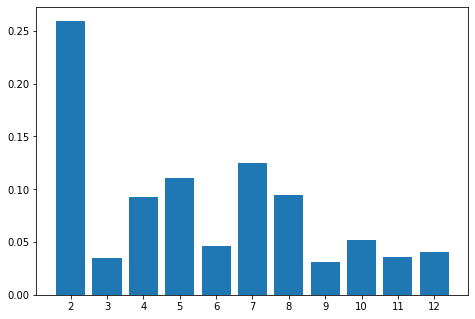

2.0
Below are results for 0 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]


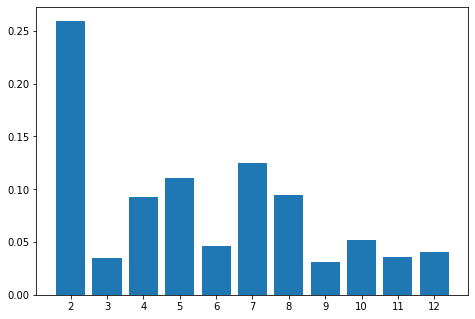

2.0
Below are results for 10 training sessoins:


KeyboardInterrupt: ignored

In [ ]:
enemyAI = [cantStopCode.pure_random_AI, cantStopCode.random_timid_AI, cantStopCode.runner_weights_AI]
theta = initTheta(theta)
THETA = theta
visualizeTheta(theta)
trainVals = [0,10,50]
GAMENUM = 10
theta = trainAndCheckProgress(theta,enemyAI,trainVals,aiDecision)

# Okay what happened.



It seems that with the current set up, our AI basically loses 99% of the time. 
After a significant amount of thinking and reworking the problem, this can be fixed with one simple change. Force our AI actor to choose the best option presented to us. This comes from a very simple difference. 
### Unlike before, we can directly change our probabilties through our policy functions.
The following code block changes this one line and runs the same code. 

In [ ]:
# The actor which spits a choice based upon its probability distribution
def aiDecision(active_player_index, player_col_state, choices, legal, random_key, theta = THETA, PLAYER_COL_STATE_INIT=jnp.array([3,5,7,9,11,13,11,9,7,5,3])):
  # Inputs:
  # same as earlier.
  # Outputs:
  # choice_index; an integer represetning the chosen option
  # roll_again; a bollean; representing if the player ends its turn
  thetaToChooseFrom = aiChoiceProbabilistic(choices,legal,theta)
  choice_index =  jnp.argmax(thetaToChooseFrom)
  roll_again = random.random() > aiRollProbabilistic(choices, choice_index, theta)[0] # if = 1, then approx 70% to roll again
  return (choice_index, roll_again)


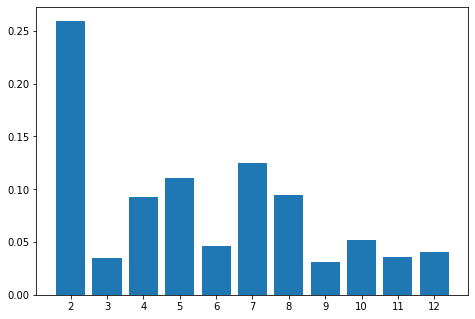

2.0
Below are results for 0 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done


KeyboardInterrupt: ignored

In [ ]:
enemyAI = [cantStopCode.pure_random_AI, cantStopCode.random_timid_AI, cantStopCode.runner_weights_AI]
theta = initTheta(theta)
THETA = theta
visualizeTheta(theta)
trainVals = [0,10,50,100,200]
theta = trainAndCheckProgress(theta,enemyAI,trainVals,aiDecision)
np.savetxt('satVal.txt', theta, fmt='%f')

## Analysis of the new AI 
This produces a much better AI with a much stronger performance. 
<br>


# Including the behaviour profile
We haven’t even included the other points. 
Let’s see what happens if we do that.
Easiest done as in below.



In [ ]:
# Outputs the prob dist for choosing columns
def aiChoiceProbabilisticLearn(choices, legal, theta):
  # Inputs:
  # choices, legal, theta as defined earlier
  # Outputs:
  # thetaToChooseFrom = An np array of size (11,) which is the probability distribution of our AI choosing any of the columns
  scoredOptions = (choices @ theta[0:11]) # scores our current options
  thetaToChooseFrom =jnn.softmax(legal*scoredOptions) # generates prob dist using softmax
  return (thetaToChooseFrom[0],thetaToChooseFrom[1],thetaToChooseFrom[2],thetaToChooseFrom[3],
          thetaToChooseFrom[4],thetaToChooseFrom[5],thetaToChooseFrom[6],thetaToChooseFrom[7],
          thetaToChooseFrom[8],thetaToChooseFrom[9],thetaToChooseFrom[10])

In [ ]:
# We compute the gradient as a.... global function? mainly to save time. This is very ugly in terms of coding practice, but its REALLY convinent 
# deals with the roll again chance
logAiProbRand = (lambda a,b,c : jnp.log(aiRollProbabilistic(a,b,c)[0]), lambda a,b,c : jnp.log(aiRollProbabilistic(a,b,c)[1]) ) # obfuscated but efficient
gradLogAiProbRand = jax.jit(jax.grad(logAiProbRand[0], argnums=(2))), jax.jit(jax.grad(logAiProbRand[1], argnums=(2))) # obfuscated but efficient
# deals with the behaviour profile, theta
logAiProbChoice = (lambda a,b,c : jnp.log(aiChoiceProbabilisticLearn(a,b,c)[0]), lambda a,b,c : jnp.log(aiChoiceProbabilisticLearn(a,b,c)[1]), lambda a,b,c : jnp.log(aiChoiceProbabilisticLearn(a,b,c)[2]),
                   lambda a,b,c : jnp.log(aiChoiceProbabilisticLearn(a,b,c)[3]), lambda a,b,c : jnp.log(aiChoiceProbabilisticLearn(a,b,c)[4]), lambda a,b,c : jnp.log(aiChoiceProbabilisticLearn(a,b,c)[5]),
                   lambda a,b,c : jnp.log(aiChoiceProbabilisticLearn(a,b,c)[6]), lambda a,b,c : jnp.log(aiChoiceProbabilisticLearn(a,b,c)[7]), lambda a,b,c : jnp.log(aiChoiceProbabilisticLearn(a,b,c)[8]),
                   lambda a,b,c : jnp.log(aiChoiceProbabilisticLearn(a,b,c)[9]), lambda a,b,c : jnp.log(aiChoiceProbabilisticLearn(a,b,c)[10]))

gradLogAiProbChoice = (jax.jit(jax.grad(logAiProbChoice[0], argnums=(2))), jax.jit(jax.grad(logAiProbChoice[1], argnums=(2))), jax.jit(jax.grad(logAiProbChoice[2], argnums=(2))),
                       jax.jit(jax.grad(logAiProbChoice[3], argnums=(2))), jax.jit(jax.grad(logAiProbChoice[4], argnums=(2))), jax.jit(jax.grad(logAiProbChoice[5], argnums=(2))),
                       jax.jit(jax.grad(logAiProbChoice[6], argnums=(2))), jax.jit(jax.grad(logAiProbChoice[7], argnums=(2))), jax.jit(jax.grad(logAiProbChoice[8], argnums=(2))),
                       jax.jit(jax.grad(logAiProbChoice[9], argnums=(2))), jax.jit(jax.grad(logAiProbChoice[10], argnums=(2))))


# the function that actually does the learning, note we assume we won the last game and our reward is 1
def changeTheta(theta,playerStateRecord,playerActionRecord, reward, learningRate = 0.5):
  # Inputs
  # theta; a 12 sized jnp array, this is the 'policy' we are training 
  # playerStateRecord; a list with dimensions [t,5] 5 being from our state at every time step (active_player_index, player_col_state, runner_choices, runner_legal, theta)
  # playerActionRecord; a list with dimensions [t,2] 2 being from our actions at every time step (choice index, roll again state) 
  # Outputs
  # theta; updated via policy grad method
  if reward != 0: # note, we just ignore the data set if the reward is 0 since our player lost those
    for t in range(1,len(playerActionRecord)): 
      colChoice = int(playerActionRecord[t][0])
      rollChoice = int(playerActionRecord[t][1])
      pCol = playerStateRecord.col[t]
      pChoice = playerStateRecord.choice[t]
      pLegal = playerStateRecord.legal[t]
      theta+= learningRate*(gradLogAiProbRand[rollChoice](pChoice,colChoice,theta)) # chooses derivative based on our roll again choice
      theta+= learningRate*gradLogAiProbChoice[colChoice](pChoice,pLegal,theta) # chooses derivative based on our column choice
  return(theta)

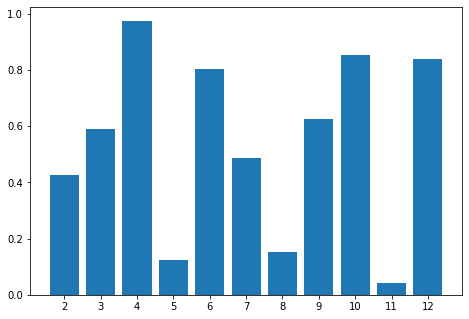

Satisfy Value is: -4.593320481175445


NameError: ignored

In [ ]:
enemyAI = [cantStopCode.pure_random_AI, cantStopCode.random_timid_AI, cantStopCode.runner_weights_AI]
theta = initTheta(theta)
THETA = theta
visualizeTheta(theta)
trainVals = [0,10,50,100,200]
theta = trainAndCheckProgress(theta,enemyAI,trainVals,aiDecision)
np.savetxt('behaviour.txt', theta, fmt='%f')

# Incorporate greedy

## Greed
Greed occurs when a player sees that they have almost finished a column. That is to say, a player who is only 1 runner position from finishing a column may roll to finish that column. In doing so they consider that finishing the column is worth the risk of busting, despite what might normally be seen. Greed therefore changes the want of a column depending on how close a player is to finished. We can model greeds affect on a single column by the following function. 
$$ g*(\frac{P_{Pi}}{L_i}) $$
We can tack on this new number onto $\theta$, modify the player scoring, and AI decision function by including the greediness into them and do the machine learning just as before. To incorporate this, we need to think of how our machine learning will change. Given that we have a new parameter we somehow need to incorporate its changes into our system. This can be done by including another value into aiChoiceProbabilistic, that being greedy.



> Changed our ai functions to incorporate greedy

In [ ]:
# The deterministic actor
def aiChoiceProbabilistic(pState,choices, legal, theta, greedy, active = 1, PLAYER_COL_STATE_INIT=jnp.array([3,5,7,9,11,13,11,9,7,5,3])):
  # Inputs:
  # active_player_index, player_col_state, choices, legal, random_key defined as in the library
  # theta = An np array of size (12,) with theta[0:11] being its preferences and theta[10] being its satisfy value
  # Outputs:
  # choice_index; an integer represetning the chosen option
  # roll_again; a bollean; representing if the player ends its turn
  scoredOptions = (choices @ theta[0:11]) # scores our current options
  greed = (PLAYER_COL_STATE_INIT - pState[active] + choices) @ jnp.reciprocal(PLAYER_COL_STATE_INIT) * theta[12]
  thetaToChooseFrom =jnn.softmax(legal*jnp.add(scoredOptions,greed)) # chooses best option that maximizes score 
  return thetaToChooseFrom

# The actor which spits a choice based upon its probability distribution
def aiDecision(active_player_index, player_col_state, choices, legal, random_key, theta = THETA, PLAYER_COL_STATE_INIT=jnp.array([3,5,7,9,11,13,11,9,7,5,3])):
  # Inputs:
  # same as earlier
  # Outputs:
  # choice_index; an integer represetning the chosen option
  # roll_again; a bollean; representing if the player ends its turn
  thetaToChooseFrom = aiChoiceProbabilistic(player_col_state,choices,legal,theta,theta[12],active_player_index)
  choice_index =  jnp.argmax(thetaToChooseFrom)
  roll_again = random.random() > aiRollProbabilistic(choices, choice_index, theta)[0] # if = 1, then approx 70% to roll again
  return (choice_index, roll_again)

### Other changes

> Had it spit out the greedy value

In [ ]:
# Outputs the prob dist for choosing columns
def aiChoiceProbabilisticLearn(pState,choices, legal, theta, active = 1, PLAYER_COL_STATE_INIT=jnp.array([3,5,7,9,11,13,11,9,7,5,3])):
  # Inputs:
  # choices, legal, theta as defined earlier
  # Outputs:
  # thetaToChooseFrom = An np array of size (11,) which is the probability distribution of our AI choosing any of the columns
  scoredOptions = (choices @ theta[0:11]) # scores our current options
  greed = (PLAYER_COL_STATE_INIT - pState[active] + choices) @ jnp.reciprocal(PLAYER_COL_STATE_INIT) * theta[12]
  thetaToChooseFrom =jnn.softmax(legal*jnp.add(scoredOptions,greed)) # chooses best option that maximizes score 
  return (thetaToChooseFrom[0],thetaToChooseFrom[1],thetaToChooseFrom[2],thetaToChooseFrom[3],
          thetaToChooseFrom[4],thetaToChooseFrom[5],thetaToChooseFrom[6],thetaToChooseFrom[7],
          thetaToChooseFrom[8],thetaToChooseFrom[9],thetaToChooseFrom[10], thetaToChooseFrom[12])

> Added a function to take the greedy derivative properly

In [ ]:
# We compute the gradient as a.... global function? mainly to save time. This is very ugly in terms of coding practice, but its REALLY convinent 
# deals with the roll again chance
logAiProbRand = (lambda a,b,c : jnp.log(aiRollProbabilistic(a,b,c)[0]), lambda a,b,c : jnp.log(aiRollProbabilistic(a,b,c)[1]) ) # obfuscated but efficient
gradLogAiProbRand = jax.jit(jax.grad(logAiProbRand[0], argnums=(2))), jax.jit(jax.grad(logAiProbRand[1], argnums=(2))) # obfuscated but efficient
# deals with the behaviour profile, theta
logAiProbChoice = (lambda a,b,c,d : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d)[0]), lambda a,b,c,d : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d)[1]), lambda a,b,c,d : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d)[2]),
                   lambda a,b,c,d : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d)[3]), lambda a,b,c,d : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d)[4]), lambda a,b,c,d : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d)[5]),
                   lambda a,b,c,d : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d)[6]), lambda a,b,c,d : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d)[7]), lambda a,b,c,d : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d)[8]),
                   lambda a,b,c,d : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d)[9]), lambda a,b,c,d : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d)[10]))

gradLogAiProbChoice = (jax.jit(jax.grad(logAiProbChoice[0], argnums=(3))), jax.jit(jax.grad(logAiProbChoice[1], argnums=(3))), jax.jit(jax.grad(logAiProbChoice[2], argnums=(3))),
                       jax.jit(jax.grad(logAiProbChoice[3], argnums=(3))), jax.jit(jax.grad(logAiProbChoice[4], argnums=(3))), jax.jit(jax.grad(logAiProbChoice[5], argnums=(3))),
                       jax.jit(jax.grad(logAiProbChoice[6], argnums=(3))), jax.jit(jax.grad(logAiProbChoice[7], argnums=(3))), jax.jit(jax.grad(logAiProbChoice[8], argnums=(3))),
                       jax.jit(jax.grad(logAiProbChoice[9], argnums=(3))), jax.jit(jax.grad(logAiProbChoice[10], argnums=(3))))


# the function that actually does the learning, note we assume we won the last game and our reward is 1
def changeTheta(theta,playerStateRecord,playerActionRecord, reward, learningRate = 0.5):
  # Inputs
  # theta; a 12 sized jnp array, this is the 'policy' we are training 
  # playerStateRecord; a list with dimensions [t,5] 5 being from our state at every time step (active_player_index, player_col_state, runner_choices, runner_legal, theta)
  # playerActionRecord; a list with dimensions [t,2] 2 being from our actions at every time step (choice index, roll again state) 
  # Outputs
  # theta; updated via policy grad method
  if reward != 0: # note, we just ignore the data set if the reward is 0 since our player lost those
    for t in range(1,len(playerActionRecord)): 
      colChoice = int(playerActionRecord[t][0])
      rollChoice = int(playerActionRecord[t][1])
      pCol = playerStateRecord.col[t]
      pChoice = playerStateRecord.choice[t]
      pLegal = playerStateRecord.legal[t]
      theta+= learningRate*(gradLogAiProbRand[rollChoice](pChoice,colChoice,theta)) # chooses derivative based on our roll again choice
      theta+= learningRate*(gradLogAiProbChoice[colChoice](pCol,pChoice,pLegal,theta))


  return(theta)

you would think the below is needed to incorporate greed.... but it isnt! Cool.

In [ ]:
# # deals with greed
# logAiProbGreed = (lambda a,b,c,d,e : jnp.log(aiChoiceProbabilisticLearn(a,b,c,d,e)[0]), lambda a,b,c,d,e: jnp.log(aiChoiceProbabilisticLearn(a,b,c,d,e)[1]), lambda a,b,c,d,e: jnp.log(aiChoiceProbabilisticLearn(a,b,c,d,e)[2]),
#                    lambda a,b,c,d,e: jnp.log(aiChoiceProbabilisticLearn(a,b,c,d,e)[3]), lambda a,b,c,d,e: jnp.log(aiChoiceProbabilisticLearn(a,b,c,d,e)[4]), lambda a,b,c,d,e: jnp.log(aiChoiceProbabilisticLearn(a,b,c,d,e)[5]),
#                    lambda a,b,c,d,e: jnp.log(aiChoiceProbabilisticLearn(a,b,c,d,e)[6]), lambda a,b,c,d,e: jnp.log(aiChoiceProbabilisticLearn(a,b,c,d,e)[7]), lambda a,b,c,d,e: jnp.log(aiChoiceProbabilisticLearn(a,b,c,d,e)[8]),
#                    lambda a,b,c,d,e: jnp.log(aiChoiceProbabilisticLearn(a,b,c,d,e)[9]), lambda a,b,c,d,e: jnp.log(aiChoiceProbabilisticLearn(a,b,c,d,e)[10]))

# gradLogAiProbGreed = (jax.jit(jax.grad(logAiProbGreed[0], argnums=(4))), jax.jit(jax.grad(logAiProbGreed[1], argnums=(4))), jax.jit(jax.grad(logAiProbGreed[2], argnums=(4))),
#                        jax.jit(jax.grad(logAiProbGreed[3], argnums=(4))), jax.jit(jax.grad(logAiProbGreed[4], argnums=(4))), jax.jit(jax.grad(logAiProbGreed[5], argnums=(4))),
#                        jax.jit(jax.grad(logAiProbGreed[6], argnums=(4))), jax.jit(jax.grad(logAiProbGreed[7], argnums=(4))), jax.jit(jax.grad(logAiProbGreed[8], argnums=(4))),
#                        jax.jit(jax.grad(logAiProbGreed[9], argnums=(4))), jax.jit(jax.grad(logAiProbGreed[10], argnums=(4))))


#  + gradLogAiProbGreed[colChoice](pCol,pChoice,pLegal,theta,theta[12])) # chooses derivative based on our column choice, includes greedy

> Added the greedy value and cleaned up visualizeTheta

In [ ]:
def visualizeTheta(theta) :
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  vals = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
  ax.bar(vals,theta[0:11])
  plt.show()
  print(f"Satisfy Value is: {theta[11]}")
  print(f"Greedy value is: {theta[12]}")

> Also initialized the greedy value with initTheta

In [ ]:
def initTheta(theta, randKey = key):
  theta = jrandom.exponential(key, shape=(13,))
  theta = theta.at[-2].set(2) # sat val
  theta = theta.at[-1].set(1.5) # greed val
  return(theta)


# Running greedy

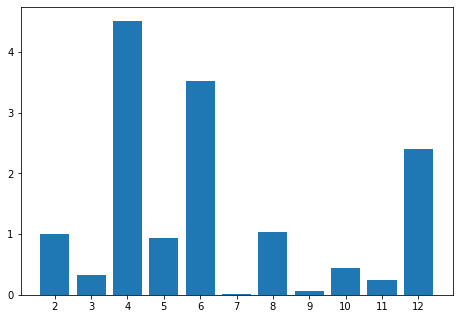

Satisfy Value is: 2.0
Greedy value is: 1.5
Below are results for 0 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]


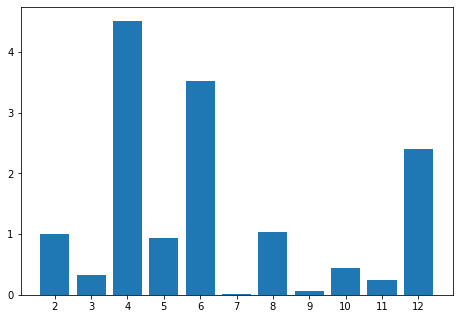

Satisfy Value is: 2.0
Greedy value is: 1.5
Below are results for 10 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]


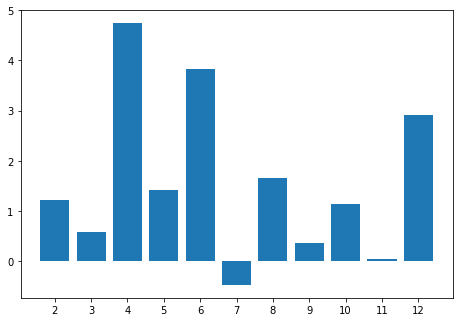

Satisfy Value is: -3.146584987640381
Greedy value is: 1.6844737529754639
Below are results for 50 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]


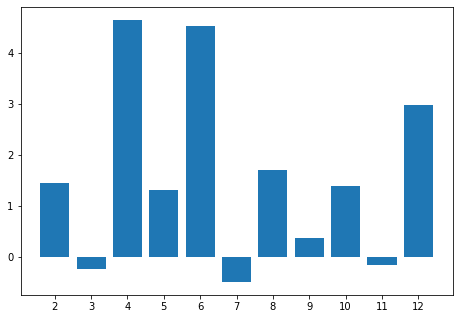

Satisfy Value is: -4.641198635101318
Greedy value is: 1.7609316110610962
Below are results for 100 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]


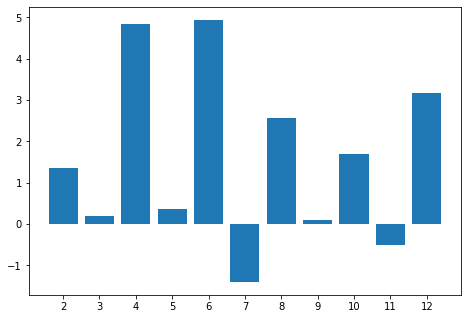

Satisfy Value is: -5.653548717498779
Greedy value is: 1.7964907884597778
Below are results for 200 training sessoins:
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [ 0 10]


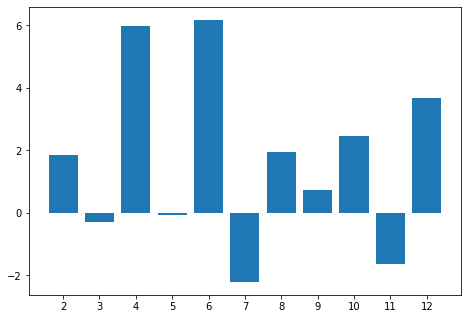

Satisfy Value is: -8.02653980255127
Greedy value is: 2.3209447860717773


In [ ]:
enemyAI = [cantStopCode.pure_random_AI, cantStopCode.random_timid_AI, cantStopCode.runner_weights_AI]
theta = initTheta(theta)
THETA = theta
visualizeTheta(theta)
trainVals = [0,10,50,100,200]
theta = trainAndCheckProgress(theta,enemyAI,trainVals,aiDecision)
np.savetxt('greedy.txt', theta, fmt='%f')

## Greedy does work? 
It seems that incorporating greedy doesn't actually help our AI. This might be from its implementation or perhaps how the function is being optimized. We will analyze this greedy implemented AI against the others shortly. 

# Another method (Evolutiuonary Algorithim)


In so far, we have been using machine learning to train our AI. But there is another way. Since we have a small number of parameters, we can just guess at what they should be. If we guess let’s say 10 times, and then see which guess is best. We can then take the best guess, slightly change it 9 times and see which is best between the 9 changed versions an the original 'best'. This process of slighly changing, an seeing which is best can be done infinitely, hopefully ending in a good final AI. <br>
This process is known as _evolutionary computation_ and only requires two things.
- One, a good representation of 'best' means. If this isn't good then our AIs will trend to become worse, and may even get stuck in certain "optimal" positions. 
- Two, the state space cannot be incredibly huge <br>
Note: since the greedy parameter doesnt seem to help our AI, we will only train the behaviour profile and satisfy value. 




## Defining best
Finding what 'best' means might be a little difficult, since we want an AI that can beat most other AI's, we will simply say one is better than the other if it can other AI's most often. Thus the AI with the highest win number of wins against the three training AIs will be considered the "best". 


## Implementing this in code
- We need a function that can generate thetas (we already have this)
- We need a function that can change the elements of theta
- We need a function that counts the number of wins an AI gets <br>
This is done below. 



In [ ]:
# Initializes theta, but with random values for the greed and satisfy value
def initTheta(theta):
  random.seed()
  theta = np.random.rand(12,)
  theta[-1] = (random.uniform(-5, 5)) # sat val
  return(theta)

# visualizeTheta
def visualizeTheta(theta) :
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  vals = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
  ax.bar(vals,theta[0:11])
  plt.show()
  print(f"Satisfy Value is: {theta[11]}")

# changes a random number of values, a random amount between 0 and 1
def pointMutation(theta):
  random.seed()
  numberOfChanges = random.randint(0, 11)
  for v in range(numberOfChanges+1):
    changeAt = random.randint(0, 11)
    theta[changeAt] += random.uniform(-1,1)
  return(theta)

# finds the best theta that preforms against the enemy AIs 
def findScore(theta,aiDecision,enemyAI,tourneyLength = 20):
  score = 0
  global THETA
  THETA = theta
  for t in range(tourneyLength):
    for enemy in enemyAI:
      score += our_play_N_games(tourneyLength,[aiDecision,enemy])
  return(score)
    
#Stealing from the Cant Stop code, we need to modify the play N games code to return the number of winners
def our_play_N_games(N_games, AIs, N_PLAYERS = 2):
  winners = jnp.zeros(N_PLAYERS,dtype=jnp.dtype('i4'))
  for i in range(N_games):
    winners += cantStopCode.simulate_game(AIs)
  return(winners[0])

# trains an evolutionary comp AI 
def trainAIEC(ourAI,enemyAI,numberOfAllTournies, tourneyLength,tourneySize):
  thetas = np.zeros(((tourneySize + 1),12)) # inits thetas
  tScores = np.zeros((tourneySize + 1),)
  best = 0
  global THETA
  for m in range(tourneySize): # starts with random intialization
    thetas[m] = initTheta(thetas[m]) 
  for numberOfTournies in numberOfAllTournies:
    for n in range(numberOfTournies):  # plays n tournies

      for m in range(tourneySize): # scores everyone
        tScores[m] = findScore(thetas[m],ourAI,enemyAI,tourneyLength) 

      best = np.argmax(tScores) # takes best score

      for m in range(tourneySize): # mutates around best
        if m != best: # dodges itself
          thetas[m] = pointMutation(thetas[best]) 
      
      thetas[-1] = initTheta(thetas[-1]) # keep one random so we dont get "stuck"
    visualizeTheta(thetas[best])
    print(f"After {numberOfTournies} tournies with size {tourneySize} tournies, {len(enemyAI)} enemies and {tourneyLength} games per")
    THETA = thetas[best]
    for idx,enemy in enumerate(enemyAI):
      print(f"Against AI {idx}")
      cantStopCode.play_N_games(10,[aiDecision,enemy])
  return(thetas[best])

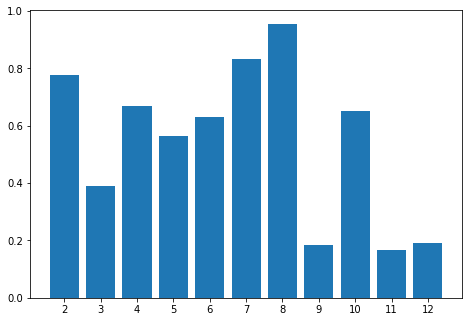

Satisfy Value is: 2.719589148480729
After 0 tournies with size 8 tournies, 3 enemies and 3 games per
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [9 1]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [5 5]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [4 6]


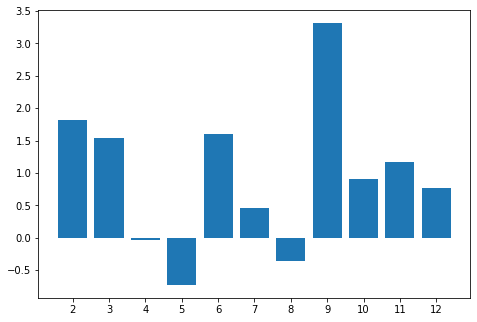

Satisfy Value is: -0.6435641596907511
After 2 tournies with size 8 tournies, 3 enemies and 3 games per
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [9 1]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [4 6]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [4 6]


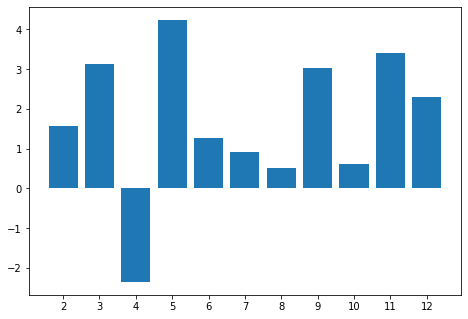

Satisfy Value is: -1.667747561829223
After 5 tournies with size 8 tournies, 3 enemies and 3 games per
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [7 3]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [5 5]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [4 6]


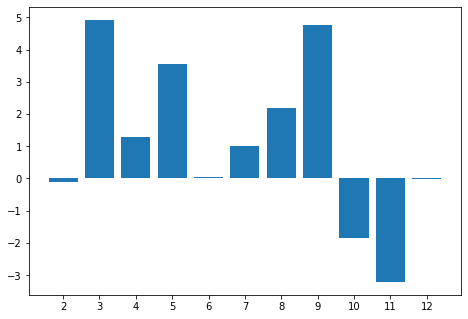

Satisfy Value is: -3.209070968569725
After 10 tournies with size 8 tournies, 3 enemies and 3 games per
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [7 3]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [5 5]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  10  winners are  [3 7]


In [ ]:
theta = jnn.softmax(jrandom.exponential(key, shape=(12,))) # I need this so it doesnt complain

enemyAI = [cantStopCode.pure_random_AI, cantStopCode.random_timid_AI, cantStopCode.runner_weights_AI]
trainVals = [0,2,5,10]
tourneyLength = 3
tourneySize = 8
theta = trainAIEC(aiDecision,enemyAI,trainVals,tourneyLength,tourneySize)
np.savetxt('ecMethod.txt', theta, fmt='%f')



Now, while this code is much less optimized than the other methods, it is incredibly slower. Only doing the about 15 episodes above took nearly the same time as the near 1000 episodes done for the policy gradient method. 

# Analyzing all methods
Since we saved all of our thetas, we will now just read them off and make them play against the enemy AI set 100 times each. The one that wins the most will be the one we submit. Cool!

For trained AI 1


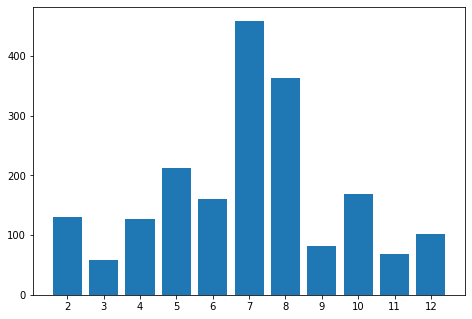

Satisfy Value is: -954.0
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [101  19]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [70 50]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [36 84]
For trained AI 1


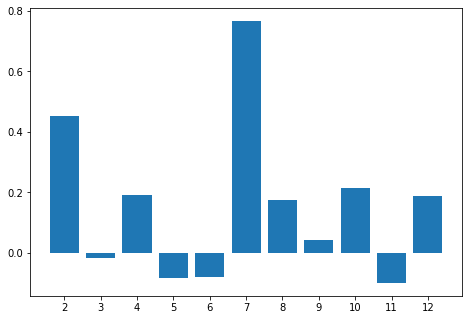

Satisfy Value is: -6.271734
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [99 21]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [53 67]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [35 85]
For trained AI 1


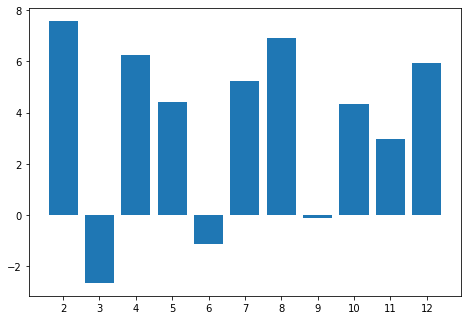

Satisfy Value is: -11.012225
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [105  15]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [65 55]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [29 91]
For trained AI 1


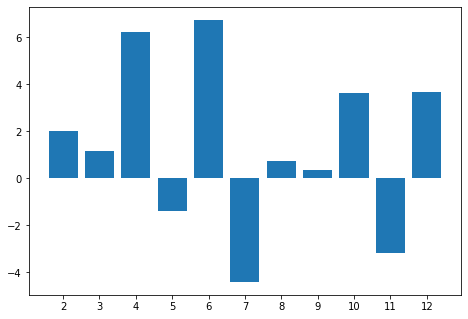

Satisfy Value is: -10.803008
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [91 29]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [66 54]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [53 67]
For trained AI 1


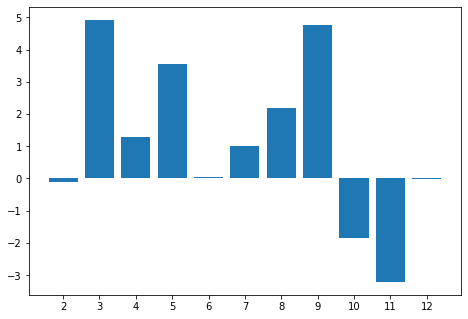

Satisfy Value is: -3.209071
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [101  19]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [63 57]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [29 91]


In [ ]:
novel = np.loadtxt('novel.txt', dtype=float)
satVal = np.loadtxt('satVal.txt', dtype=float)
behaviour = np.loadtxt('behaviour.txt', dtype=float)
greedy = np.loadtxt('greedy.txt', dtype=float)
evoComp = np.loadtxt('ecMethod.txt', dtype=float)
allMadeAIs = [novel,satVal,behaviour,greedy,evoComp]
enemyAI = [cantStopCode.pure_random_AI, cantStopCode.random_timid_AI, cantStopCode.runner_weights_AI]
for idx2,ai in enumerate(allMadeAIs):
  print(f"For trained AI {idx2}")
  THETA = ai # swaps in our trained AI 
  visualizeTheta(THETA)
  for idx2,enemy in enumerate(enemyAI):
    print(f"Against AI {idx2}")
    cantStopCode.play_N_games(120,[aiDecision,enemy])



## Greedy did... well?
It may be surprising that greedy preformed the best out of our trained AIs and it is. However, this is due to greedy requiring different code to run. In short, it yielded an extremely good result when we didnt include its greedy parameter. Somehow the greedy parameter helped trained the AI but doesnt help in its gameplay. We will be these weights for our AI that only uses a satisfy value and its behaviour profile, since inclusion of greedy leads to the win rates of of: [27 93] against the pure random Ai and _no wins_ against the more advanced AIs. 



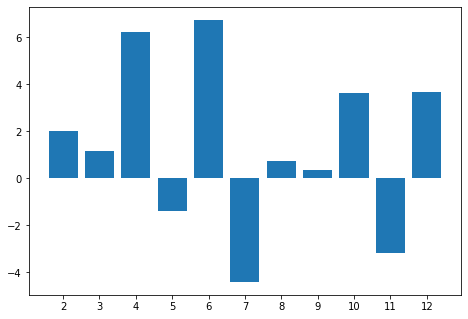

Satisfy Value is: -10.803008
Greedy value is: 3.581077
Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [27 93]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [  0 120]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [  0 120]


In [ ]:
# The deterministic actor
def aiChoiceProbabilistic(pState,choices, legal, theta, active = 1, PLAYER_COL_STATE_INIT=jnp.array([3,5,7,9,11,13,11,9,7,5,3])):
  # Inputs:
  # active_player_index, player_col_state, choices, legal, random_key defined as in the library
  # theta = An np array of size (12,) with theta[0:11] being its preferences and theta[10] being its satisfy value
  # Outputs:
  # choice_index; an integer represetning the chosen option
  # roll_again; a bollean; representing if the player ends its turn
  scoredOptions = (choices @ theta[0:11]) # scores our current options
  greed = (PLAYER_COL_STATE_INIT - pState[active] + choices) @ jnp.reciprocal(PLAYER_COL_STATE_INIT) * theta[12]
  thetaToChooseFrom =jnn.softmax(legal*jnp.add(scoredOptions,greed)) # chooses best option that maximizes score 
  return thetaToChooseFrom

# The actor which spits a choice based upon its probability distribution
def aiDecision(active_player_index, player_col_state, choices, legal, random_key, theta = THETA, PLAYER_COL_STATE_INIT=jnp.array([3,5,7,9,11,13,11,9,7,5,3])):
  # Inputs:
  # same as earlier
  # Outputs:
  # choice_index; an integer represetning the chosen option
  # roll_again; a bollean; representing if the player ends its turn
  thetaToChooseFrom = aiChoiceProbabilistic(player_col_state,choices,legal,theta,active_player_index)
  choice_index =  jnp.argmax(thetaToChooseFrom)
  roll_again = random.random() > aiRollProbabilistic(choices, choice_index, theta)[0] # if = 1, then approx 70% to roll again
  return (choice_index, roll_again)

def visualizeTheta(theta) :
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  vals = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
  ax.bar(vals,theta[0:11])
  plt.show()
  print(f"Satisfy Value is: {theta[11]}")
  print(f"Greedy value is: {theta[12]}")

greedy = np.loadtxt('greedy.txt', dtype=float)
THETA = greedy
visualizeTheta(THETA)
for idx2,enemy in enumerate(enemyAI):
  print(f"Against AI {idx2}")
  cantStopCode.play_N_games(120,[aiDecision,enemy])


# Our Machine learned AI

Here is the single file we will submit. 

In [ ]:
# Outputs the prob dist for choosing columns
def aiChoiceProbabilistic(choices, legal, theta):
  # Inputs:
  # choices, legal, theta as defined earlier
  # Outputs:
  # thetaToChooseFrom = An np array of size (11,) which is the probability distribution of our AI choosing any of the columns
  scoredOptions = (choices @ theta[0:11]) # scores our current options
  thetaToChooseFrom =jnn.softmax(legal*scoredOptions) # generates prob dist using softmax
  return (thetaToChooseFrom)

# Outputs the prob dist for choosing to roll again
def aiRollProbabilistic(choices, choice_index, theta):
  scoredOptions = (choices @ theta[0:11])
  rollAgainChance = (jnp.arctan(scoredOptions[choice_index] - theta[11]) + 1.5)/3# = ~ 0.04 if 3 behind the satisfy value . 
  return([rollAgainChance, 1 - rollAgainChance])

def aiDecision(active_player_index, player_col_state, choices, legal, random_key, theta = THETA, PLAYER_COL_STATE_INIT=jnp.array([3,5,7,9,11,13,11,9,7,5,3])):
  # Inputs:
  # same as earlier.
  # Outputs:
  # choice_index; an integer represetning the chosen option
  # roll_again; a bollean; representing if the player ends its turn
  thetaToChooseFrom = aiChoiceProbabilistic(choices,legal,theta)
  choice_index =  jnp.argmax(thetaToChooseFrom)
  roll_again = random.random() > aiRollProbabilistic(choices, choice_index, theta)[0] # if = 1, then approx 70% to roll again
  return (choice_index, roll_again)


THETA = greedy = np.loadtxt('greedy.txt', dtype=float)




Sanity check to make sure it works

In [ ]:
# nothing new about this, just helped with running stuff in the jyupter notebook
def initTheta(theta, randKey = key, satVal = 2):
  theta = jnn.softmax(jrandom.exponential(randKey, shape=(12,)))
  theta = theta.at[-1].set(satVal)
  return(theta)

# nothing new about this, just helped with running stuff in the jyupter notebook
def visualizeTheta(theta) :
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  vals = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
  ax.bar(vals,theta[0:11])
  plt.show() # behaviour profile
  print(theta[11]) # sat val

for idx2,enemy in enumerate(enemyAI):
  print(f"Against AI {idx2}")
  cantStopCode.play_N_games(120,[aiDecision,enemy])


Against AI 0
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [102  18]
Against AI 1
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [70 50]
Against AI 2
0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
After  120  winners are  [31 89]


# Other things we could do, but did not have time for


To better run our AI we could have done a large number of things. Each thing will be mentioned, explaining how it _should_ affect the AI and why we chose not to incorporate it.
- Vectorization: From our work we found good success against the training AI given after a few hundred sessions. Since this took only a few minutes, we thought there would be no need to vectorize it. If we were to vectorize it, we would need to change our changeTheta function to do some a vector product between our thetas and our gradients. 
- Learing rate scaling: Normally when you do machine learning, you allow the machine to learng at a variable rate. This represents having faith that your AI will start to converge to some solution after the initial set of updates. This could have even pushed us to do vectorization as we may have needed considerably more runs to train our AI. Though because of the seemingly good optima that is reached in a relatively short number of trianing sessions, we thought there was no need to actually scale our learning rate. (For the evolutionary algorithim this could have come in the form of different mutation types). 
- Incorporate a critic function: We could have incorporated a critic function to faster training. If implemented, we could have used a 'specalized critic' where we would only look for certain actions and then learn from these. (For example, if our AI went from losing to winning, learng from this turn). This would let us avoid having to change the critic function and would have let us look for certain types of strategies specifically. 
- Evolutionary algorith self play: We could have had it train against itself, but it would involve changing the simulation again and couple of other tedious changes. Instead, we decided to only play against the enemy AIs as provided in the library. 
- Evolutionary algorithim better fitness function: We could have generated a better fitness function that just straight win percentages. One of these could have been incorporating how many times one of our AI's was ahead with columns. The rational being if a has more column completed then their enemies for longer, then they are actually playing very well. 
- Optimizing the evolutionary algorithim: The evolutionary algorithim was pretty succesful at its training but had a ration of 100*1 in terms of time it took to train each episode. This insane increase in time is probably due to operations that are just not optimal that being used. This should have been optimized in some sort of way. For example, the Evo Alg could have looked at the total number of turns an AI was ahead of its opponent for less games, or the physical calculations could have been better implmented.  
- Looking at our enemies: We could have explicitly looked at the enemy’s board state. This was technically never done. Mainly as it was planned as an extension to greedy and given greedy's preformance it was scrapped. This is probably the biggest missed change that would have made our AI signifincatly more successful.

